In [4]:
import pandas as pd

In [6]:
df = pd.read_csv("GWB1223.csv")
print(df.head)

<bound method NDFrame.head of              Date  Latitude  Longitude     Tmax     Tmin  Rain
0      2012-01-01      21.5       85.5  28.4500  17.2400   0.0
1      2012-01-02      21.5       85.5  27.2000  17.6800   0.0
2      2012-01-03      21.5       85.5  27.5600  17.5100   0.0
3      2012-01-04      21.5       85.5  25.6300  17.6900   0.0
4      2012-01-05      21.5       85.5  27.8700  18.0000   0.0
...           ...       ...        ...      ...      ...   ...
87655  2023-12-27      25.5       88.5  26.8010  14.3240   0.0
87656  2023-12-28      25.5       88.5  26.5231  14.2974   0.0
87657  2023-12-29      25.5       88.5  26.9411  13.7122   0.0
87658  2023-12-30      25.5       88.5  24.7878  13.9715   0.0
87659  2023-12-31      25.5       88.5  23.4209  13.3619   0.0

[87660 rows x 6 columns]>


In [8]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [10]:
grids = df[['Latitude', 'Longitude']].drop_duplicates()
print("Total grids:", len(grids))

Total grids: 20


In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [14]:
df = df.loc[:,~df.columns.duplicated()] # Duplicated Data cleaning
df['Date'] = pd.to_datetime(df['Date']) # Date time format
print("Missing values: \n",df.isnull().sum())

Missing values: 
 Date         0
Latitude     0
Longitude    0
Tmax         0
Tmin         0
Rain         0
dtype: int64


21.5 85.5


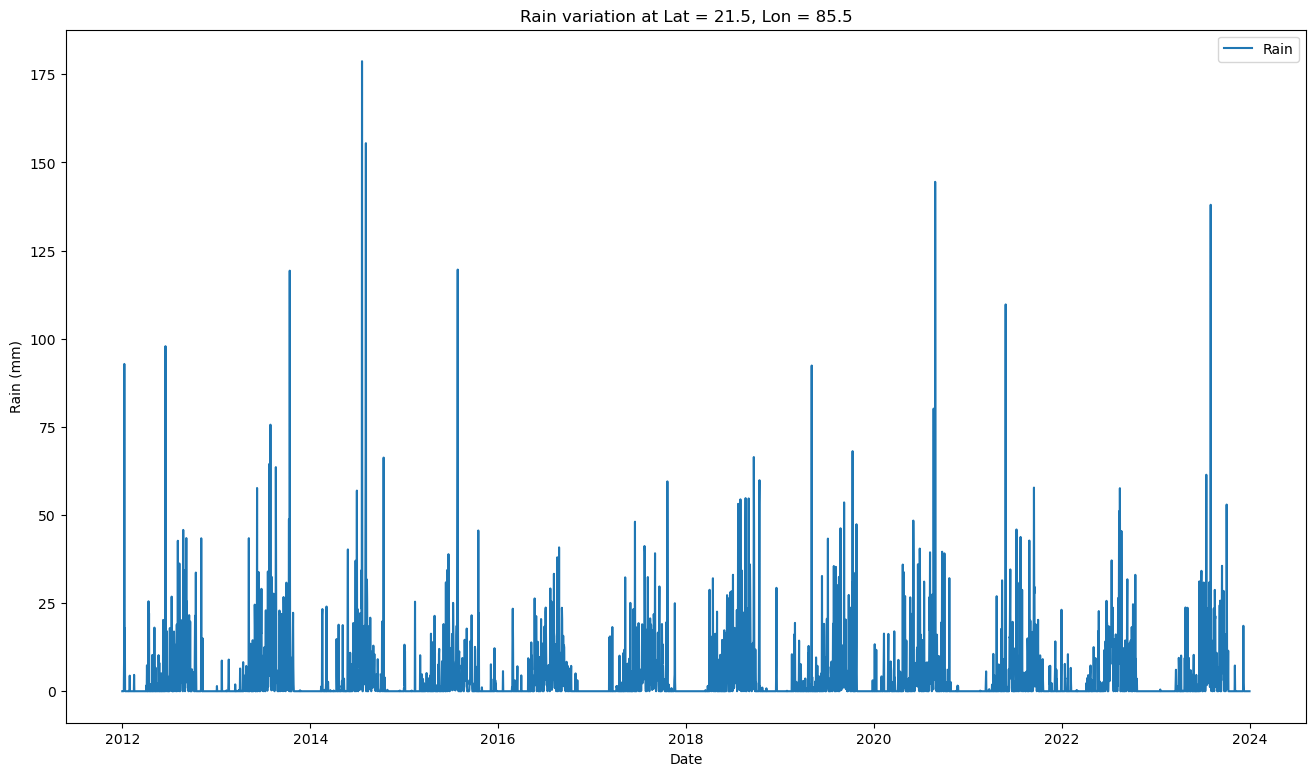

In [16]:
lat0 = df['Latitude'].iloc[0]
lon0 = df['Longitude'].iloc[0]
print(lat0,lon0)
grid_df = df[(df['Latitude'] == lat0) & (df['Longitude'] == lon0)]
#print(grid_df.head())
plt.figure(figsize=(16,9))
plt.plot(grid_df['Date'],grid_df['Rain'],label='Rain')
#plt.plot(grid_df['Date'],grid_df['Tmin'],label='Tmin')
plt.title(f"Rain variation at Lat = {lat0}, Lon = {lon0}")
plt.xlabel('Date')
plt.ylabel('Rain (mm)')
plt.legend()
plt.show()
#plt.savefig("Temp_singleGrid.png",dpi=300)

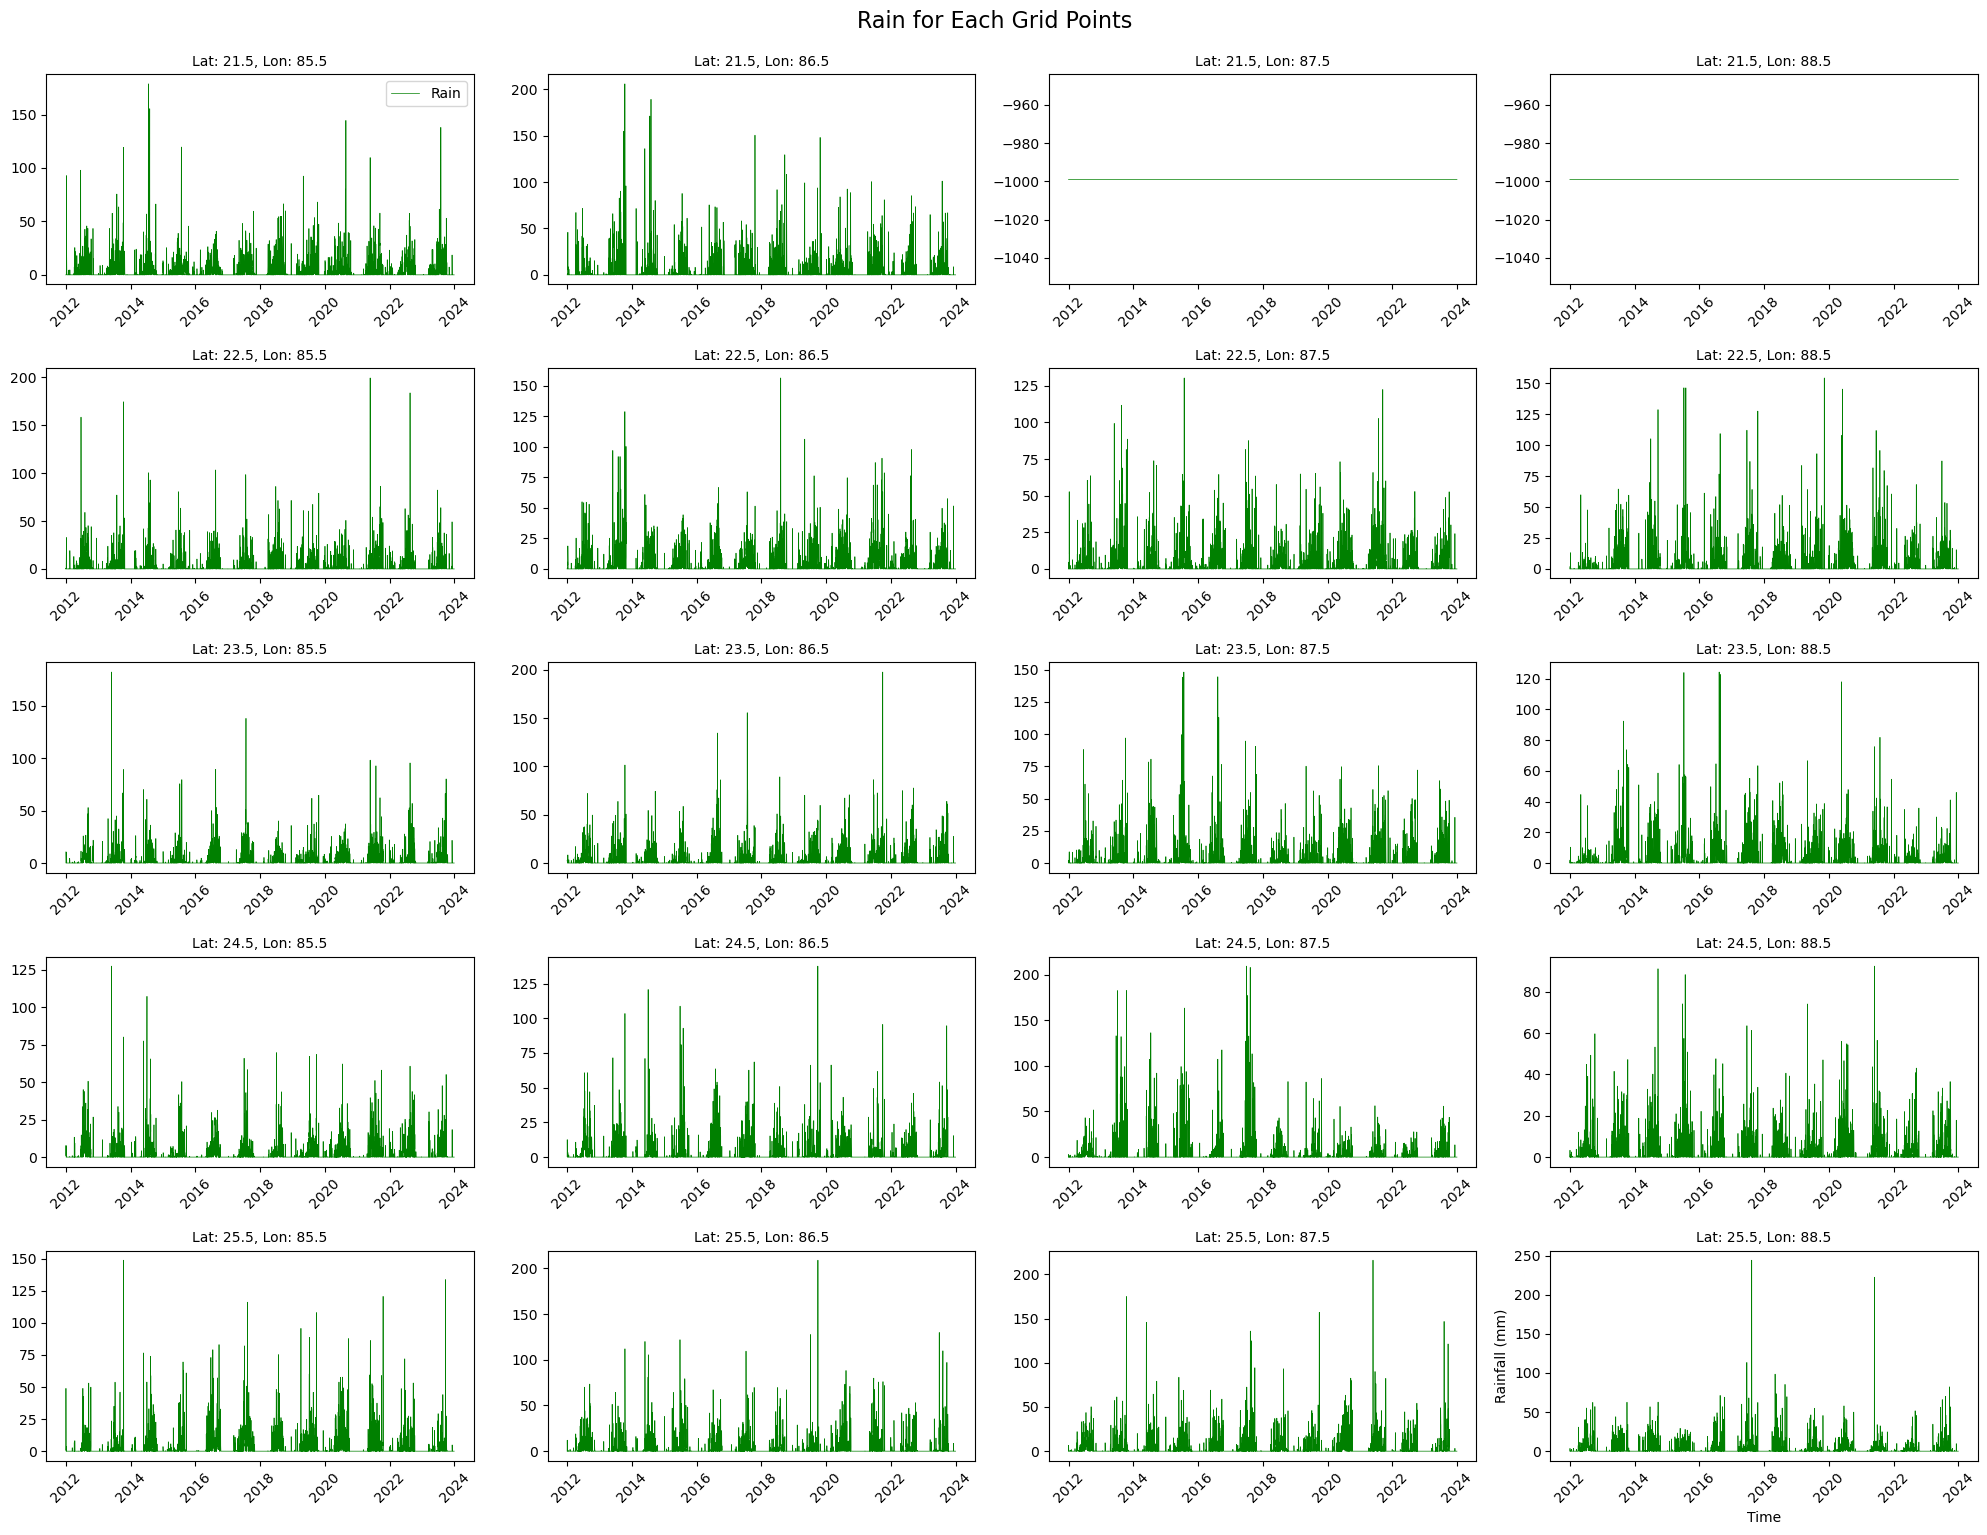

In [22]:
grid_points = df[['Latitude', 'Longitude']].drop_duplicates().values
n = len(grid_points)
rows = 5
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()
for i, (lat, lon) in enumerate(grid_points):
    grid_df = df[(df['Latitude'] == lat) & (df['Longitude'] == lon)]
    axes[i].plot(grid_df['Date'], grid_df['Rain'], label='Rain', color='green', linewidth=0.5)
    axes[i].set_title(f'Lat: {lat}, Lon: {lon}', fontsize=10)
    axes[i].tick_params(axis='x', labelrotation=45)
    axes[0].legend()
plt.xlabel("Time")
plt.ylabel("Rainfall (mm)")
plt.tight_layout()
plt.suptitle("Rain for Each Grid Points", fontsize=16, y=1.02)
plt.subplots_adjust(hspace=0.4)
plt.show()
#plt.savefig("temperature_all_grids.png", dpi=300)

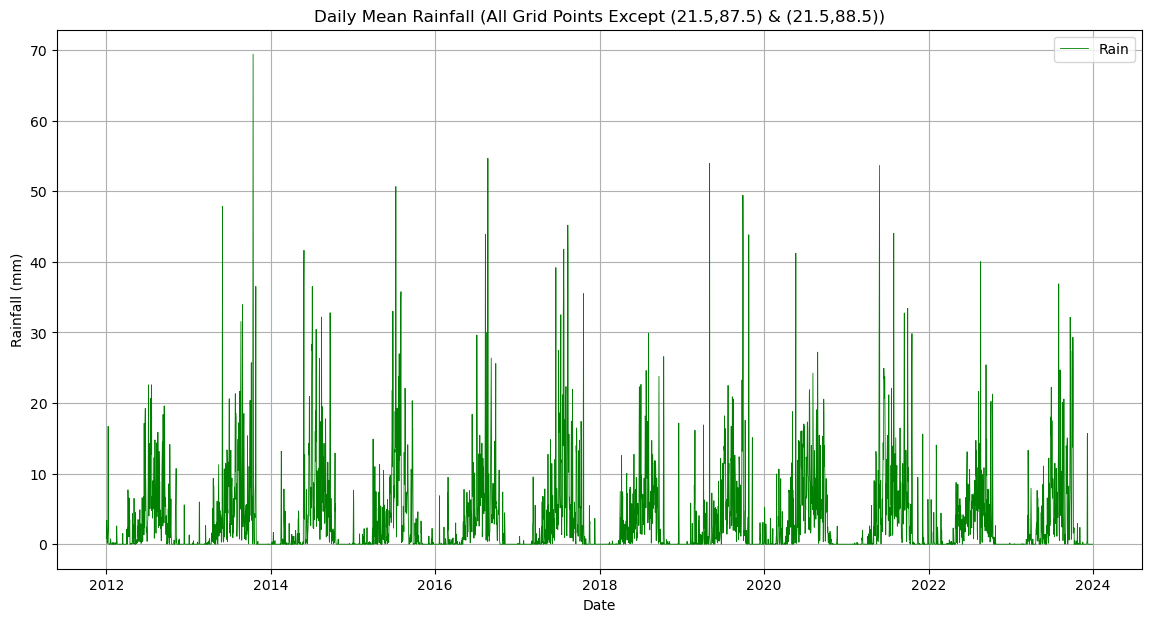

In [129]:
# Exclude specific grid points
df_filtered = df[~((df['Latitude'] == 21.5) & (df['Longitude'].isin([87.5, 88.5])))]

# Calculate daily mean across remaining grid points
daily_mean = df_filtered.groupby('Date')[['Tmax', 'Tmin', 'Rain']].mean().reset_index()
daily_mean.to_csv("daily_mean_data.csv", index=False)

# Convert Date column to datetime
daily_mean['Date'] = pd.to_datetime(daily_mean['Date'])

# Plot
plt.figure(figsize=(14, 7))
plt.plot(daily_mean['Date'], daily_mean['Rain'], label='Rain', color='green', linewidth=0.6)
plt.title("Daily Mean Rainfall (All Grid Points Except (21.5,87.5) & (21.5,88.5))")
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True)
plt.show()


In [131]:
print(daily_mean.columns)

Index(['Date', 'Tmax', 'Tmin', 'Rain'], dtype='object')


In [133]:
daily_mean['Year'] = daily_mean['Date'].dt.year
daily_mean['Month'] = daily_mean['Date'].dt.month
monthly_mean = daily_mean.groupby(['Year', 'Month'])[['Tmax', 'Tmin', 'Rain']].mean().reset_index()
monthly_mean['Date'] = pd.to_datetime(monthly_mean[['Year', 'Month']].assign(DAY=1))

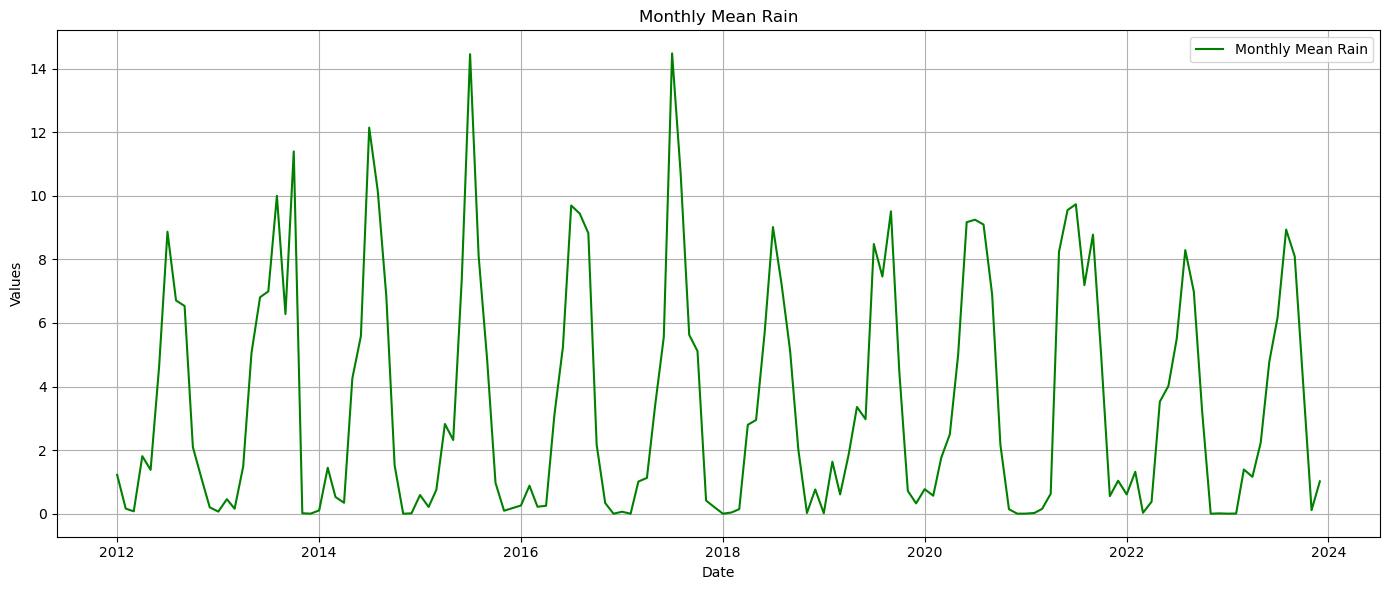

In [135]:
plt.figure(figsize=(14, 6))
plt.plot(monthly_mean['Date'], monthly_mean['Rain'], label='Monthly Mean Rain', color='green')
plt.title("Monthly Mean Rain")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

In [137]:
import seaborn as sns
from sklearn.linear_model import LinearRegression

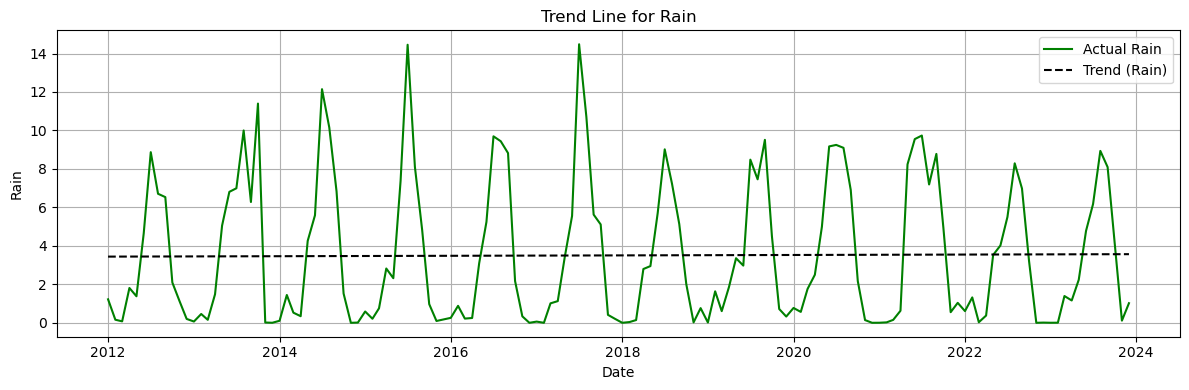

Trend line equation for Rain: Rain= 0.00003 * Date + -17.99
Rate of change in Rain per day: 0.00003 mm
Rate of change in Rain per year: 0.011 mm/year 
Rate of change in Rain per decade: 0.107 mm/decade 



In [139]:
monthly_mean['Ordinal'] = monthly_mean['Date'].map(pd.Timestamp.toordinal)
def fit_and_plot_trend(y_col, color):
    X = monthly_mean[['Ordinal']]
    y = monthly_mean[y_col]
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    plt.figure(figsize=(12, 4))
    plt.plot(monthly_mean['Date'], y, label=f'Actual {y_col}', color=color)
    plt.plot(monthly_mean['Date'], y_pred, '--', label=f'Trend ({y_col})', color='black')
    plt.title(f"Trend Line for {y_col}")
    plt.xlabel("Date")
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
fit_and_plot_trend('Rain', 'green')
X = monthly_mean[['Ordinal']]
y = monthly_mean['Rain']
model = LinearRegression()
model.fit(X, y)
slope = model.coef_[0]
intercept = model.intercept_
print(f"Trend line equation for Rain: Rain= {slope:.5f} * Date + {intercept:.2f}")
print(f"Rate of change in Rain per day: {slope:.5f} mm")
print(f"Rate of change in Rain per year: {slope*365:.3f} mm/year ")
print(f"Rate of change in Rain per decade: {slope*365*10:.3f} mm/decade \n")


In [141]:
from statsmodels.tsa.seasonal import seasonal_decompose

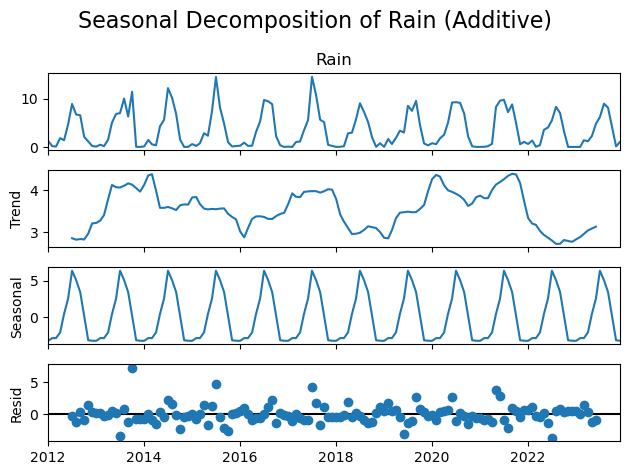

In [143]:
monthly_mean.set_index('Date', inplace=True)
result = seasonal_decompose(monthly_mean['Rain'], model='additive', period=12)
result.plot()
plt.suptitle('Seasonal Decomposition of Rain (Additive)', fontsize=16)
plt.tight_layout()
plt.show()


In [145]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

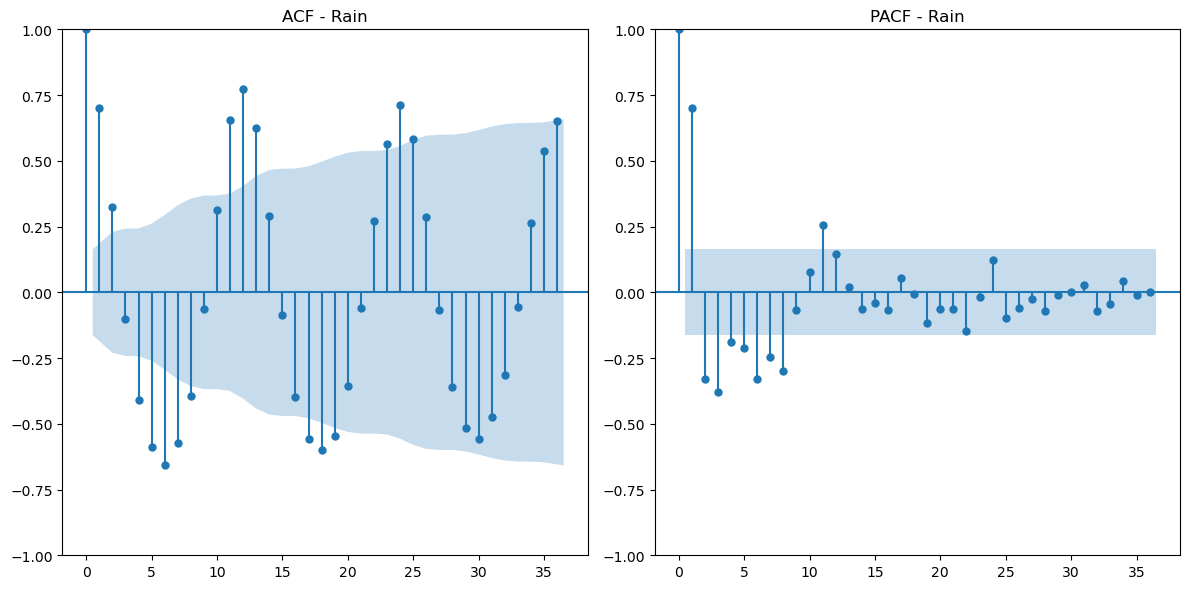

In [147]:
# ACF - PACF Plot for Rain
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plot_acf(monthly_mean['Rain'].dropna(), lags=36, ax=plt.gca())
plt.title('ACF - Rain')
plt.subplot(1, 2, 2)
plot_pacf(monthly_mean['Rain'].dropna(), lags=36, ax=plt.gca(), method='ywm')
plt.title('PACF - Rain')
plt.tight_layout()

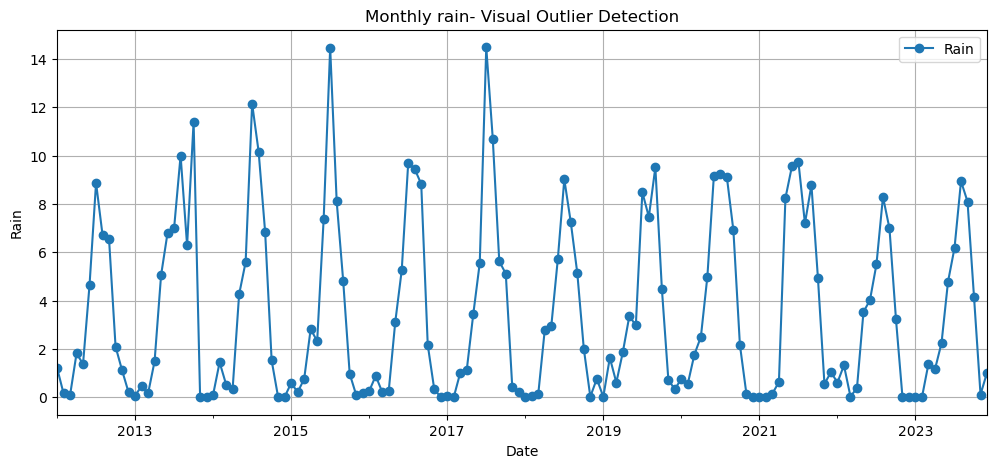

No outlier found in Rain. 



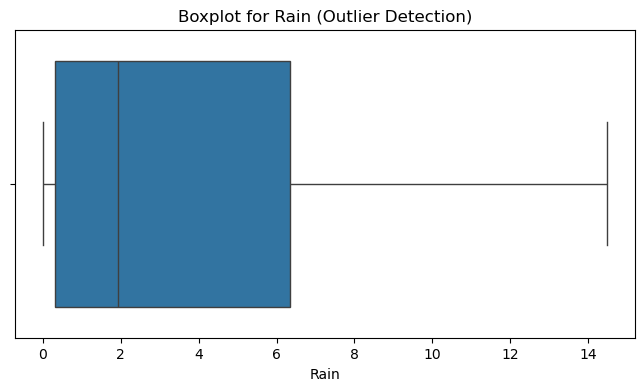

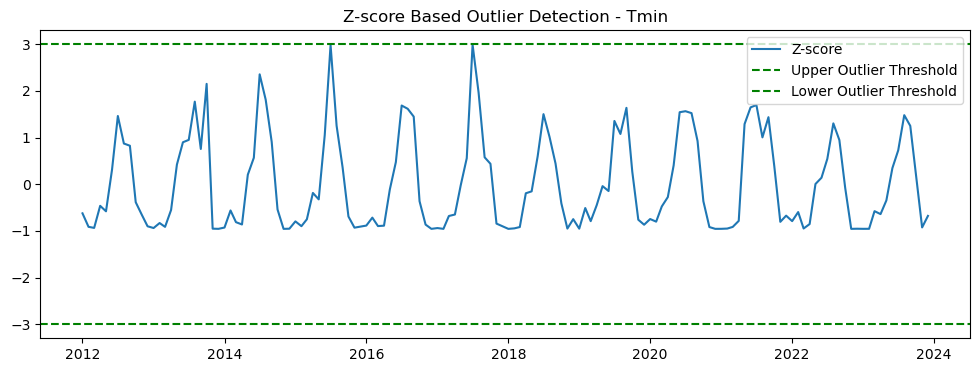

In [159]:
monthly_mean['Rain'].plot(figsize=(12,5), marker='o', label='Rain')
plt.title("Monthly rain- Visual Outlier Detection")
plt.ylabel("Rain")
plt.grid(True)
plt.legend()
plt.show()
print("No outlier found in Rain. \n")
plt.figure(figsize=(8, 4))
sns.boxplot(x=monthly_mean['Rain'])
plt.title("Boxplot for Rain (Outlier Detection)")
plt.show()
Rain = monthly_mean['Rain']
z_scores = (Rain- Rain.mean()) / Rain.std()
plt.figure(figsize=(12,4))
plt.plot(Rain.index, z_scores, label='Z-score')
plt.axhline(3, color='green', linestyle='--', label='Upper Outlier Threshold')
plt.axhline(-3, color='green', linestyle='--', label='Lower Outlier Threshold')
plt.title("Z-score Based Outlier Detection - Tmin")
plt.legend()
plt.show()

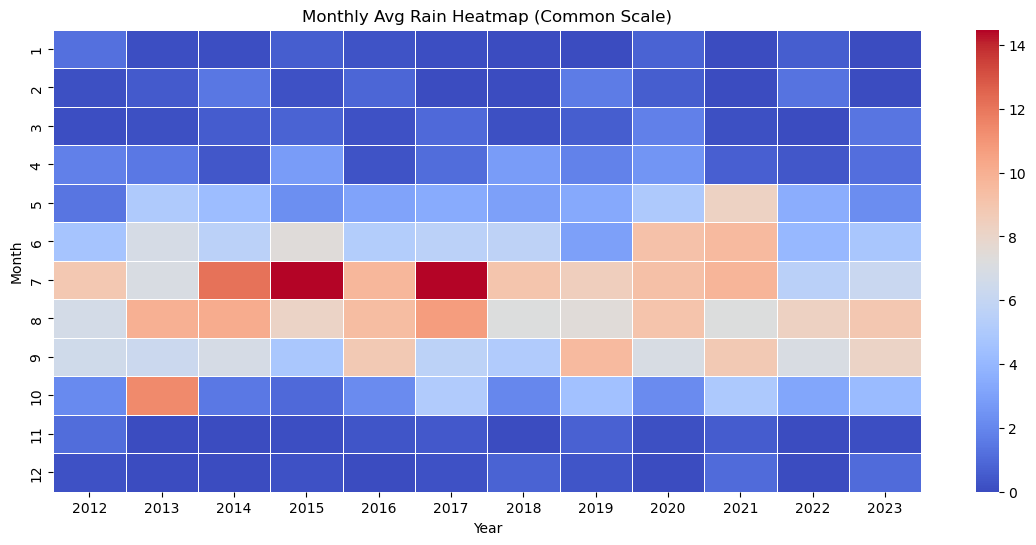

In [155]:
pivot_Rain = monthly_mean.pivot_table(index='Month', columns='Year', values='Rain')
plt.figure(figsize=(14,6))
sns.heatmap(pivot_Rain, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('Monthly Avg Rain Heatmap (Common Scale)')
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()

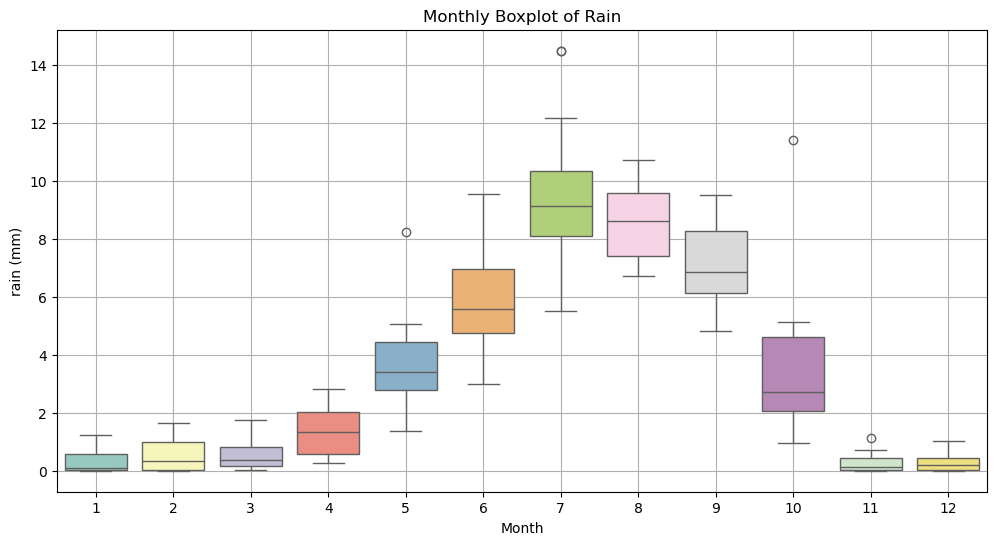

In [157]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Month', y='Rain', data=monthly_mean, hue='Month',
palette='Set3', legend=False)
plt.title('Monthly Boxplot of Rain')
plt.xlabel('Month')
plt.ylabel('rain (mm)')
plt.grid(True)
plt.show()